### Assignment 1: Automatic pieces detection and quantification in thermographic images


#### Steps:
1. Load images  
2. Preprocess (grayscale, normalization, smoothing)  
3. Threshold - binary mask  
4. Morphological cleaning  
5. Contour detection  
6. Filter using area, circularity, and “touching border” test  
7. Draw results, count pieces, and save annotated images + CSV file  

### Import and Setup

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,6)

# Carpeta con imágenes
IMAGE_DIR = "Images"       # Tu carpeta con 7 imágenes
OUTPUT_DIR = "output"      # Resultados anotados

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Parámetros HoughCircles
MIN_RADIUS_HOUGH = 150     # radio mínimo para círculos grandes
MAX_RADIUS_HOUGH = 200    # radio máximo (ajusta según tu imagen)
DP = 1.2                  # resolución del acumulador
MIN_DIST = 50             # distancia mínima entre centros
PARAM1 = 100              # threshold Canny interno
PARAM2 = 30               # threshold del acumulador

print("Directories ready.")


Directories ready.


#### Functions

In [29]:
def preprocess_image(img):
    """Convert to grayscale, normalize, blur to reduce noise."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Normalize contrast
    gray = gray.astype(np.float32)
    gray -= gray.min()
    if gray.max() > 0:
        gray = (gray / gray.max()) * 255
    gray = gray.astype(np.uint8)
    
    # Gaussian blur
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    return gray_blur


#### Detection

In [30]:
results = []

for fname in sorted(os.listdir(IMAGE_DIR)):
    if not fname.lower().endswith((".png", ".jpg", ".jpeg", ".tif")):
        continue

    path = os.path.join(IMAGE_DIR, fname)
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print("Cannot read:", path)
        continue

    gray_blur = preprocess_image(img_bgr)

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(
        gray_blur,
        cv2.HOUGH_GRADIENT,
        dp=DP,
        minDist=MIN_DIST,
        param1=PARAM1,
        param2=PARAM2,
        minRadius=MIN_RADIUS_HOUGH,
        maxRadius=MAX_RADIUS_HOUGH
    )

    annotated = img_bgr.copy()
    count_complete = 0

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            # Filtrar solo círculos grandes (min radius)
            if r < MIN_RADIUS_HOUGH:
                continue
            cv2.circle(annotated, (x, y), r, (0, 255, 0), 2) # borde verde
            cv2.circle(annotated, (x, y), 2, (0, 0, 255), 3) # centro rojo
            count_complete += 1

    # Guardar imagen anotada
    out_path = os.path.join(OUTPUT_DIR, f"annot_{fname}")
    cv2.imwrite(out_path, annotated)

    results.append({
        "filename": fname,
        "large_circles": count_complete
    })

    print(f"{fname}: detected {count_complete} large circles")

print("Processing complete.")


image1.png: detected 1 large circles
image2.png: detected 0 large circles
image3.png: detected 70 large circles
image4.png: detected 75 large circles
image5.png: detected 18 large circles
image6.png: detected 91 large circles
image7.png: detected 85 large circles
Processing complete.


#### Results

(np.float64(-0.5), np.float64(957.5), np.float64(637.5), np.float64(-0.5))

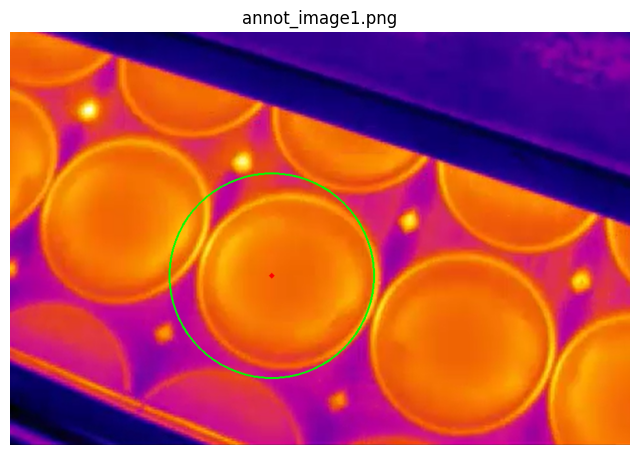

In [31]:
example = sorted(os.listdir(OUTPUT_DIR))[0]
path = os.path.join(OUTPUT_DIR, example)

img = cv2.imread(path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(example)
plt.axis("off")
